In [95]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from numpy import *

from wordcloud import WordCloud

from sklearn.metrics import completeness_score, homogeneity_score

A) Create your own distance function that, instead of using Euclidean distance, uses Cosine similarity. This is the distance function you will use to pass to the kMeans function.

In [96]:
def simCosine(vecA, vecB):
    normA = linalg.norm(vecA)
    normB = linalg.norm(vecB)
    
    cosine = dot(vecA, vecB) / (normA * normB)
    dist = 1 - cosine
    return dist

B) Load the data set [Note: the data matrix provided has terms as rows and documents as columns. Since you will be clustering documents, you'll need to take the transpose of this matrix so that your main data matrix is a document x term matrix. In Numpy, you may use the ".T" operation to obtain the transpose.] Then, split the data set (the document x term matrix) and set aside 20% for later use (see below). Use the 80% segment for clustering in the next part. The 20% portion must be a random subset.

In [97]:
# Loading in data
matrix = np.genfromtxt("newsgroups5/matrix.txt", delimiter=',', dtype=int).T
matrix.shape

(2500, 9328)

In [98]:
classes = np.genfromtxt("newsgroups5/classes.txt", delimiter=' ', dtype=int, skip_header=1, usecols=(1))
classes.shape

(2500,)

In [99]:
terms = pd.read_csv("newsgroups5/terms.txt", sep='\n', header=None)
terms.shape

(9328, 1)

In [136]:
# Splitting data set 80-20
SEED = 33
x_train, x_test, y_train, y_test = train_test_split(matrix, classes, test_size=0.2, random_state=SEED)

C) Perform Kmeans clustering on the training data. Write a function to display the top N terms in each cluster along with the cluster DF values for each term and the size of the cluster. The cluster DF value for a term t in a cluster C is the percentage of docs in cluster C in which term t appears (so, if a cluster has 500 documents, and term "game" appears in 100 of those 500 documents, then DF value of "game" in that cluster is 0.2 or 20%). Sort the terms for each cluster in decreasing order of the DF percentage. Here is an example of how this output might look like (here the top 10 terms for 3 of the 5 clusters are displayed in decreasing order of cluster DF values, but the mean frequency from the cluster centroid is also shown). [Extra Credit: use your favorite third party tool, ideally with a Python based API, to create a word cloud for each cluster.]

In [137]:
# Code implementations below are from Ch. 10 of MLA provided by professor
def distEuclid(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2))) #la.norm(vecA-vecB)

In [138]:
def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = zeros((k,n), dtype=float)
    for j in range(n): #create random cluster centers
        minJ = min(dataSet[:,j])
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = minJ + rangeJ * random.rand(k)
    return centroids

In [139]:
# kMeans function
def kMeans(dataSet, k, distMeas=distEuclid, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = zeros((m,2)) #create mat to assign data points 
                                  #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m): #for each data point assign it to the closest centroid
            minDist = inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        # print centroids
        for cent in range(k):#recalculate centroids
            ptsInClust = dataSet[nonzero(clusterAssment[:,0]==cent)[0]] #get all the point in this cluster - Note: this was incorrect in the original distribution.
            if(len(ptsInClust)!=0):
                centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean - Note condition was added 10/28/2013
    return centroids, clusterAssment

In [140]:
def biKmeans(dataSet, k, distMeas=distEuclid):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    centList =[centroid0] #create a list with one centroid
    for j in range(m): #calc initial Error
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:] #get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1]) #compare the SSE to the currrent minimum
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
            print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[nonzero(bestClustAss[:,0] == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[nonzero(bestClustAss[:,0] == 0)[0],0] = bestCentToSplit
        print('the bestCentToSplit is: ',bestCentToSplit)
        print('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0] #replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss #reassign new clusters, and SSE
    return mat(centList), clusterAssment

In [145]:
centroids, clusters = kMeans((x_train), 5, simCosine, randCent)

In [142]:
def getTopTerms(N, centroids, clusters):
    terms_list = pd.Series(terms[0], name='Term')
    clusters = pd.DataFrame(clusters)
    
    for i in range(5):
        cluster_index = np.array(clusters.index[clusters.iloc[:,0] == i])
        centroid = pd.Series(centroids[i], name='Centroid_value')
        cluster = pd.concat([terms_list, centroid], axis=1)
        cluster_len = len(cluster_index)
        print("Cluster " + str(i) + ":")
        cluster_df = cluster.iloc[cluster_index]
        cluster_df.sort_values(by='Centroid_value', axis=0, ascending=False, inplace=True)
        
        top_n = cluster_df.head(N)
        for t in top_n.itertuples():
                doc_freq = t.Centroid_value * cluster_len
                percent = t.Centroid_value * 100
                print("%10s\t%.0f\t%.6f" %(t.Term, doc_freq, percent))

In [146]:
getTopTerms(10, centroids, clusters)

Cluster 0:
 christian	599	49.668325
    church	369	30.597015
   clipper	367	30.431177
       dai	275	22.802653
    christ	255	21.144279
       ask	235	19.485904
     david	226	18.739635
    appear	203	16.832504
   against	202	16.749585
    commun	190	15.754561
Cluster 1:
    ashton	0	0.000000
   atlanta	0	0.000000
        bo	0	0.000000
    broken	0	0.000000
cypherpunk	0	0.000000
 dcsedacuk	0	0.000000
Cluster 2:
    articl	168	21.593830
    comput	156	20.051414
      call	151	19.408740
    applic	133	17.095116
       box	104	13.367609
    condit	98	12.596401
   address	89	11.439589
      case	85	10.925450
      best	81	10.411311
    access	80	10.282776
Cluster 3:
     avail	2	28.571429
    archiv	1	14.285714
  american	0	0.000000
    backup	0	0.000000
      boil	0	0.000000
      butt	0	0.000000
    combin	0	0.000000
Cluster 4:
     birth	0	0.000000
caralvautotrolcom	0	0.000000
 commision	0	0.000000


In [147]:
# Extra credit wordcloud
# Getting the clusters into a dataframe
c0 = pd.DataFrame(train[clusters[:,0]==0])
c1 = pd.DataFrame(train[clusters[:,0]==1])
c2 = pd.DataFrame(train[clusters[:,0]==2])
c3 = pd.DataFrame(train[clusters[:,0]==3])
c4 = pd.DataFrame(train[clusters[:,0]==4])

In [148]:
# Set the columns to the terms from the terms dataset
terms_array = np.array(terms)
c0.columns = terms_array.T[0]
c1.columns = terms_array.T[0]
c2.columns = terms_array.T[0]
c3.columns = terms_array.T[0]
c4.columns = terms_array.T[0]

In [149]:
# Get frequencies for each cluster
c0_freq = list(np.array((c0.T!=0).sum(1).T))
c1_freq = list(np.array((c1.T!=0).sum(1).T))
c2_freq = list(np.array((c2.T!=0).sum(1).T))
c3_freq = list(np.array((c3.T!=0).sum(1).T))
c4_freq = list(np.array((c4.T!=0).sum(1).T))

In [150]:
# creating a list of the terms and strings to hold output for the wordcloud
terms_list = list(terms_array.T[0])

c0_words = ""
c1_words = ""
c2_words = ""
c3_words = ""
c4_words = ""

In [151]:
# Creating the strings in terms of the frequency
index = 0
for i in c0_freq:
    for j in range(int(i)):
        c0_words += t_list[index] + " "
    index += 1
    
index = 0
for i in c1_freq:
    for j in range(int(i)):
        c1_words += t_list[index] + " "
    index += 1

index = 0
for i in c2_freq:
    for j in range(int(i)):
        c2_words += t_list[index] + " "
    index += 1
    
index = 0
for i in c3_freq:
    for j in range(int(i)):
        c3_words += t_list[index] + " "
    index += 1

index = 0
for i in c4_freq:
    for j in range(int(i)):
        c4_words += t_list[index] + " "
    index += 1

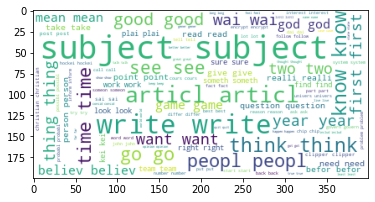

In [152]:
# Cluster 0
c0_wordcloud = WordCloud(background_color='white').generate(c0_words)
plt.imshow(c0_wordcloud)
plt.show()

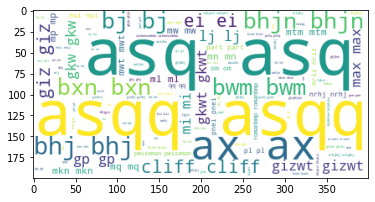

In [153]:
# Cluster 1
c1_wordcloud = WordCloud(background_color='white').generate(c1_words)
plt.imshow(c1_wordcloud)
plt.show()

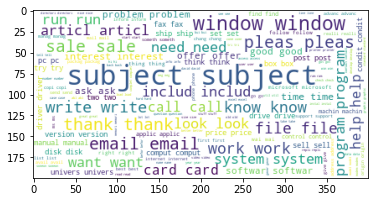

In [154]:
# Cluster 2
c2_wordcloud = WordCloud(background_color='white').generate(c2_words)
plt.imshow(c2_wordcloud)
plt.show()

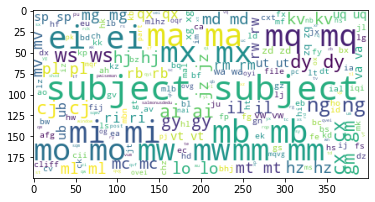

In [155]:
# Cluster 3
c3_wordcloud = WordCloud(background_color='white').generate(c3_words)
plt.imshow(c3_wordcloud)
plt.show()

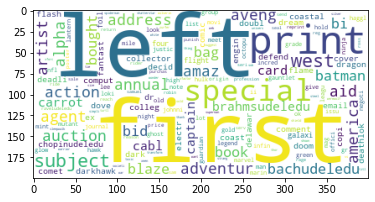

In [156]:
# Cluster 4
c4_wordcloud = WordCloud(background_color='white').generate(c4_words)
plt.imshow(c4_wordcloud)
plt.show()

D) Using the cluster assignments from Kmeans clustering, compare your 5 clusters to the 5 pre-assigned classes by computing the Completeness and Homogeneity values.

In [157]:
cscore = completeness_score(class_train, np.ravel(clusters.T[0]))
hscore = homogeneity_score(class_train, np.ravel(clusters.T[0]))
print("Completeness Score: ", cscore)
print("Homogeneity Score: ", hscore)

Completeness Score:  0.6341357206467773
Homogeneity Score:  0.283436756509891


E) Finally, using your cluster assignments as class labels, categorize each of the documents in the 20% set-aside data into each of the appropriate cluster. Your categorization should be based on Cosine similarity between each test document and cluster centroids. For each test document show the predicted class label as well as Cosine similarity to the corresponding cluster.

In [168]:
results = []

for doc in x_test:
    dic = {}
    similar = []
    cluster = 0
    for centroid in centroids:
        cluster += 1
        centroid_doc_sim = 1 - simCosine(doc, centroid)
        
        similar.append(centroid_doc_sim)
        dic[str(cluster)] = centroid_doc_sim
    dic['Predicted Cluster'] = similar.index(max(similar))+1
    results.append(dic)

In [169]:
pd.DataFrame(results)

,1,2,3,4,5,Predicted Cluster
0,0.202280,0.000023,0.132217,0.005869,0.008705,1
1,0.200940,0.000007,0.127185,0.006105,0.009241,1
2,0.143112,0.000031,0.157155,0.037270,0.011339,3
3,0.289765,0.000027,0.399106,0.015119,0.009084,3
4,0.118069,0.000018,0.162395,0.009109,0.005543,3
5,0.387213,0.000022,0.203783,0.006461,0.015125,1
6,0.369889,0.000011,0.197868,0.006860,0.009858,1
7,0.181638,0.000022,0.168525,0.005589,0.009498,1
8,0.409452,0.000006,0.166639,0.006649,0.018361,1
9,0.161002,0.000010,0.105418,0.004774,0.001228,1
